In [1]:
# Imports
import re
import pathlib
import itertools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define some useful function

def load_data(results_file, check_error=True):
    """Load and preprocess data"""
    df = pd.read_csv(results_file, sep="\t")
    # Separate out benchmark command
    warp_command = df.iloc[-1].idx
    df = df.iloc[:-1]
    # Drop some unused columns
    df = df.drop(['idx'], axis=1)
    if check_error:
        if df.error.isna().all():
            df = df.drop('error', axis=1)
        else:
            raise Exception("Errors found in df.error column")
    if df.n_objects.eq(1).all():
        df = df.drop('n_objects', axis=1)
    # Convert some data dtypes
    for col in ['start', 'end']:
        # df[col] = df[col].map(dt.datetime.fromisoformat)
        df[col] = df[col].map(lambda x: dt.datetime.strptime(x.split('.')[0], '%Y-%m-%dT%H:%M:%S'))
    
    return df, warp_command

def load_summary(filename):
    df = pd.read_csv(filename, sep="\t")
    df = df[~(df.op == "op")]
    for col in ['mb_per_sec', 'objs_per_sec']:
        df[col] = pd.to_numeric(df[col])
    return df

def parse_text_summary(filename):
    """Parses the text summary from `warp analyze ...` and generates a dict of throughput values"""
    # Read input and compile reusable regexs
    op_regex = re.compile(r"[A-Z][A-Z]+")
    score_regex = re.compile(r"[0-9]+\.[0-9]+\ [a-zA-Z]+/s")
    with open(filename, "r") as file:
        lines = file.readlines()
    # Iterate through file lines and extract relevant pieces
    scores = {}
    current_op = None
    for line in lines:
        if line.startswith("Operation: "):
            op = op_regex.search(line)[0]
            current_op = op
            scores[op] = {}
        elif line.startswith(" * Throughput: ") or line.startswith("* Average:"):
            for score in score_regex.finditer(line):
                val, units = score[0].split(" ")
                unit_type = units.split("/")[0]
                scores[current_op][unit_type + "_per_sec"] = float(val)
        elif line.startswith("Cluster Total: "):
            scores["Total"] = {}
            for score in score_regex.finditer(line):
                val, units = score[0].split(" ")
                unit_type = units.split("/")[0]
                scores["Total"][unit_type + "_per_sec"] = float(val)

    return scores  

def duration_from_filesize_heuristic(size: str):
    if 'GiB' in size:
        return '30m'
    elif 'MiB' in size:
        return '5m'
    elif 'KiB' in size:
        return '1m'
    else:
        raise Exception(f"Unable to determine run duration from file size - size '{size}' not included in heuristic")

def make_bins(df, N_bins):
    """Selects bin edges for data based on log scale"""
    data = df.bytes[df.op == "PUT"] / 1024**2
    min_size = round(data.min(), ndigits=4)
    max_size = round(data.max())
    return 10**np.linspace(np.log10(min_size), np.log10(max_size), N_bins+1)

def plot_grouped_bars(scores, unit, ax=None, op_colours=None):

    groups = list(scores.keys())
    ops = [k for k, v in scores[groups[0]].items() if unit in v.keys()]
    data = {op:[scores[g][op][unit] for g in groups] for op in ops}

    x = np.arange(len(groups))  # the label locations
    width = 1 / (1+len(ops)) # the width of the bars
    multiplier = (1.5 - len(ops)/2)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.grid(axis="y", lw=0.5, zorder=0)
    
    for i, (op, score) in enumerate(data.items()):
        offset = width * multiplier
        rects = ax.bar(
            x + offset, 
            score, 
            width, 
            ec="k", 
            label=op, 
            zorder=3,
            color=(op_colours[op] if op_colours is not None else None)
        )
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(unit.replace("_per_sec", "/s"))
    ax.set_xticks(x + width, groups)    
    
    return ax

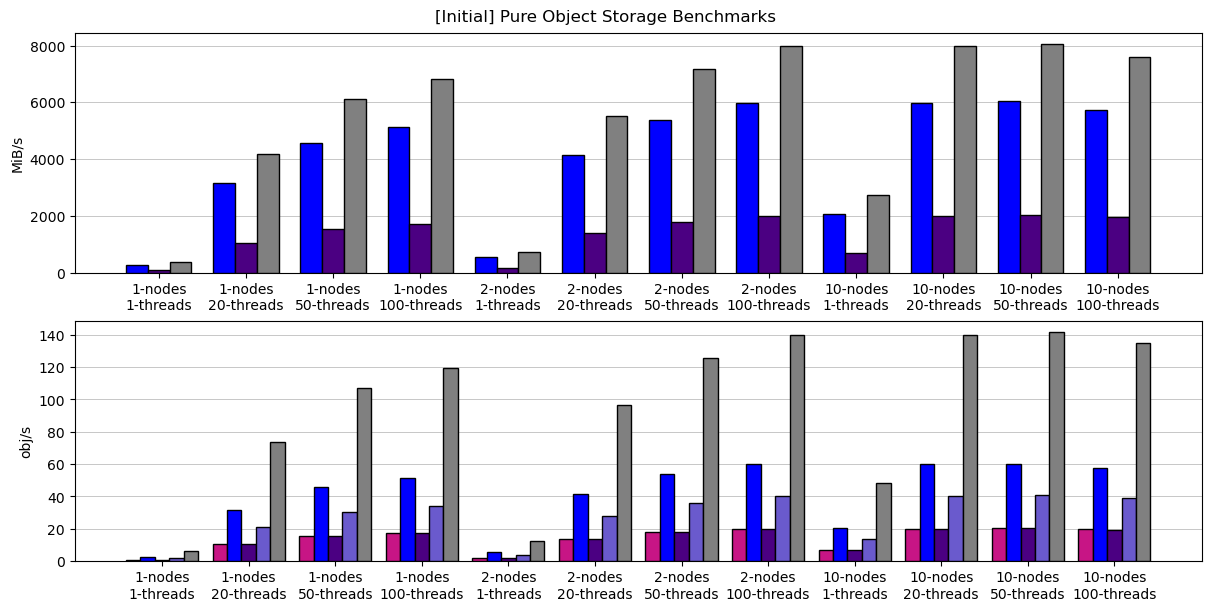

In [15]:
# Code 

obj_sizes = "100MiB"
scores = {}
for nodes, threads in itertools.product([1, 2, 10], [1, 20, 50, 100]):
    key = f"{nodes}-nodes\n{threads}-threads"
    run_scores = parse_text_summary(
        f'benchmark-runs/warp-results-summary.mixed-{nodes}-{threads}-1100-{obj_sizes}-10m.txt'
    )
    for k, v in run_scores.items():
        if v == {}:
            run_scores[k] = {"MiB_per_sec": 0, "obj_per_sec": 0}
    scores[key] = run_scores

op_colours = {"GET":"blue", "PUT":"indigo", "STAT":"slateblue", "DELETE":"mediumvioletred", "Total":"grey"}
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", axs[0], op_colours)
plot_grouped_bars(scores, "obj_per_sec", axs[1], op_colours)
fig.suptitle("[Initial] Pure Object Storage Benchmarks")
# plt.savefig("initial-pure-results.png")
plt.show()

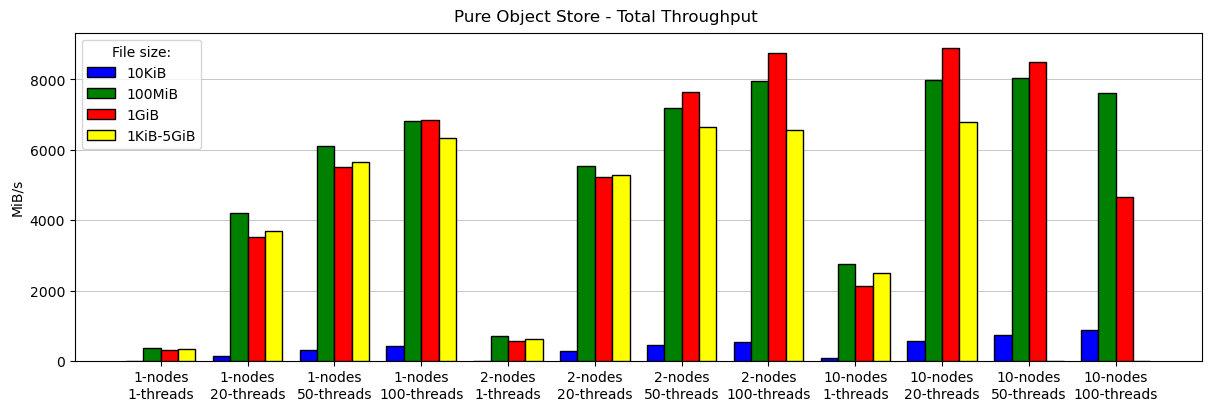

In [3]:
# Code 

scores = {}
for nodes, threads in itertools.product([1, 2, 10], [1, 20, 50, 100]):
    key = f"{nodes}-nodes\n{threads}-threads"
    scores[key] = {}
    for size in ["10KiB", "100MiB", "1GiB", "1KiB-5GiB"]:
        run_scores = parse_text_summary(
            f'benchmark-runs/warp-results-summary.mixed-{nodes}-{threads}-1100-{size}-10m.txt'
        )
        for k, v in run_scores.items():
            if v == {}:
                run_scores[k] = {"MiB_per_sec": 0, "obj_per_sec": 0}
        scores[key][size] = run_scores["Total"]
        

bar_colours = {"10KiB":"blue", "100MiB":"green", "1GiB":"red", "1KiB-5GiB": "yellow"}
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", ax, bar_colours)
ax.legend(title="File size:")
fig.suptitle("Pure Object Store - Total Throughput")
# plt.savefig("initial-pure-results-fixed-filesizes.png")
plt.show()

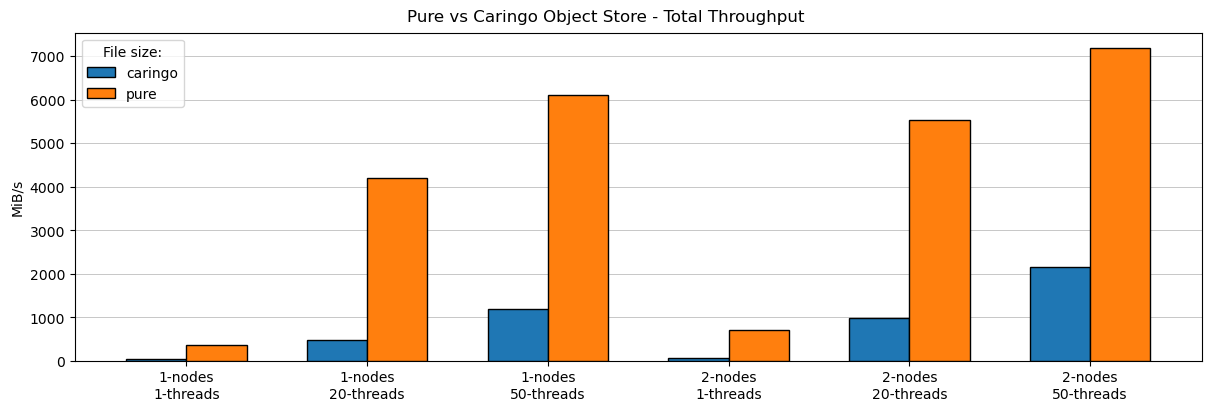

In [11]:
# Code 

scores = {}
for nodes, threads in itertools.product([1, 2], [1, 20, 50]):
    key = f"{nodes}-nodes\n{threads}-threads"
    scores[key] = {}
    # for size in ["10KiB", "100MiB", "1GiB", "1KiB-5GiB"]:
    for prefix in ["s3-caringo", "warp-results"]:
        size = '100MiB'
        duration = '-10m' if prefix == 'warp-results' else ''
        try:
            run_scores = parse_text_summary(
                f'benchmark-runs/{prefix}-summary.mixed-{nodes}-{threads}-1100-{size}{duration}.txt'
            )
            # print(run_scores)
            label = 'caringo' if prefix == 's3-caringo' else 'pure'
            for k, v in run_scores.items():
                if v == {}:
                    run_scores[k] = {"MiB_per_sec": 0, "obj_per_sec": 0}
            scores[key][label] = run_scores["Total"]
        except:
            continue
# print(scores)

bar_colours = None #{"10KiB":"blue", "100MiB":"green", "1GiB":"red", "1KiB-5GiB": "yellow"}
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", ax, bar_colours)
ax.legend(title="File size:")
fig.suptitle("Pure vs Caringo Object Store - Total Throughput")
# plt.savefig("initial-pure-results-fixed-filesizes.png")
plt.show()

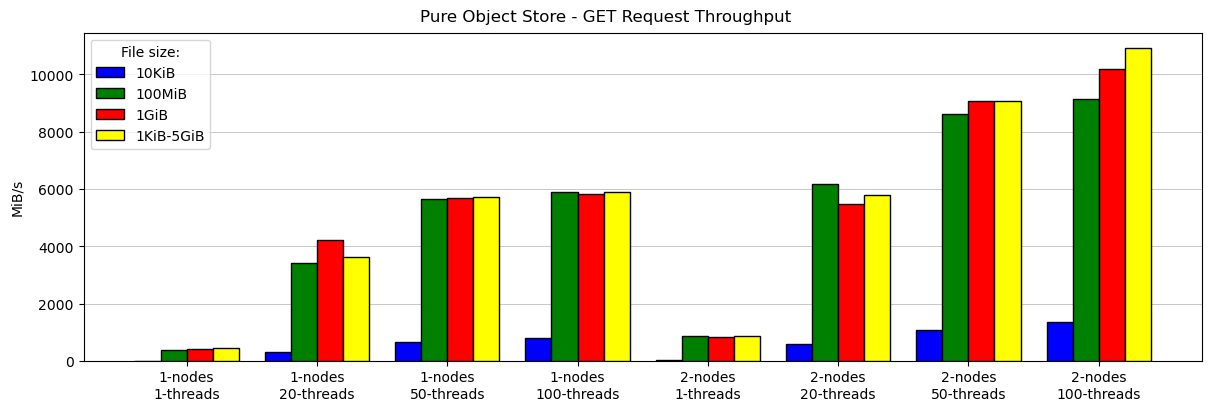

In [30]:
# Code 

OP = 'GET'
scores = {}
for nodes, threads in itertools.product([1, 2], [1, 20, 50, 100]):
    key = f"{nodes}-nodes\n{threads}-threads"
    scores[key] = {}
    for size in ["10KiB", "100MiB", "1GiB", "1KiB-5GiB"]:
        # duration = duration_from_filesize_heuristic(size)
        run_scores = parse_text_summary(
            f'benchmark-runs/s3-pure-summary.{OP.lower()}-{nodes}-{threads}-300-{size}.txt'
        )
        # print(run_scores)
        for k, v in run_scores.items():
            if v == {}:
                run_scores[k] = {"MiB_per_sec": 0, "obj_per_sec": 0}
        scores[key][size] = run_scores[OP]
# print(scores)

bar_colours = {"10KiB":"blue", "100MiB":"green", "1GiB":"red", "1KiB-5GiB": "yellow"}
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", ax, bar_colours)
ax.legend(title="File size:")
fig.suptitle(f"Pure Object Store - {OP} Request Throughput")
plt.savefig(f"initial-pure-results-fixed-filesizes-{OP}.png")
# ax.set_yscale('log')
plt.show()

In [32]:
8 * 10909.01 / 1024

85.226640625

In [10]:
8 * 8886.14 / 1024

69.42296875

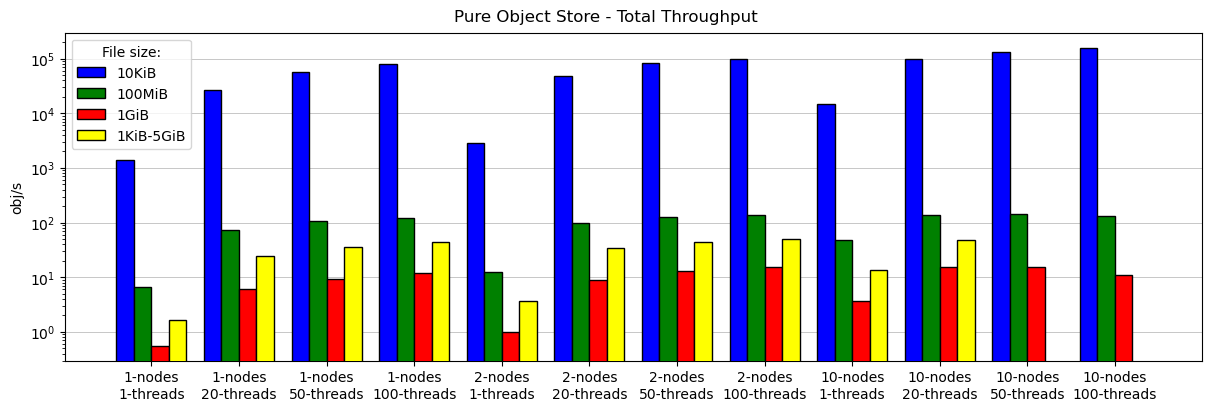

In [6]:
# Code       

bar_colours = {"10KiB":"blue", "100MiB":"green", "1GiB":"red", "1KiB-5GiB": "yellow"}
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, constrained_layout=True)
plot_grouped_bars(scores, "obj_per_sec", ax, bar_colours)
ax.legend(title="File size:")
ax.set_yscale('log')
fig.suptitle("Pure Object Store - Total Throughput")
# plt.savefig("initial-pure-results-fixed-filesizes.png")
plt.show()